In [1]:
# activate autoreload
%load_ext autoreload
%autoreload 2

# check if session is in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print('Google Colab session!')
except:
    IN_COLAB = False
    print('Not a Google Colab session.')

# add src path to the notebook
import os
import sys
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_ROOT: str = '/content/drive/MyDrive/papers/2025b_spatially-explicit-active-learning'
    !pip install contextily esda deep-translator h3pandas h3~=3.0 datasets
else:
    PROJECT_ROOT: str = os.path.dirname(os.path.abspath(os.path.dirname("__file__")))
if PROJECT_ROOT not in sys.path:
    sys.path.append(os.path.join(PROJECT_ROOT))
print(PROJECT_ROOT)

Google Colab session!
Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.3 MB/s eta 0:00:00
  Created wheel for h3pandas: filen

# 2023 Chile Wildfires: Data Preparation
In this notebook, we prepare the data set of relatedness-labelled disaster-tweets regarding the 2023 Chile wildfires from Hanny et al. (2024).

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from src.utils import clean_text_bert, build_dataset_relatedness, translate_google
sns.set_style('whitegrid')
tqdm.pandas()


# set data path
DATA_PATH: str = os.path.join(PROJECT_ROOT, 'data')
print(f'Data path: {DATA_PATH}')

# set torch device
device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    print(torch.cuda.get_device_name(0))

Data path: /content/drive/MyDrive/papers/2025b_spatially-explicit-active-learning/data


## 1. Load Data
First, let's read in the data. We merge the train/test tweets from Hanny et al. (2024) to achieve a full data set regarding the Chile wildfires.

In [ ]:
test_chile: pd.DataFrame = pd.read_parquet(os.path.join(DATA_PATH, 'raw', 'chile', 'test_chile_geom.parquet')).rename(
    columns={'message_id_x': 'message_id'}
)  # evaluation tweets
train_chile: pd.DataFrame = pd.read_parquet(os.path.join(DATA_PATH, 'raw', 'chile', 'train_chile_geom.parquet'))  # tweets used for training
chile_tweets: gpd.GeoDataFrame = gpd.read_file(os.path.join(DATA_PATH, 'raw', 'chile', 'tweets_2023_chile.geojson'), engine='pyogrio').rename(
    columns={'geometry': 'geom'}
)  # all tweets
chile_tweets = chile_tweets[['message_id', 'date', 'text', 'tweet_lang', 'geom', 'photo_url']]


print(test_chile.shape)
print(train_chile.shape)
print(chile_tweets.shape)

(371, 10)
(188, 6)
(2282470, 6)


Let's go ahead with pre-processing.

In [ ]:
# create a normalised representation of each post
if 'text_raw' not in chile_tweets.columns:
    chile_tweets['text_raw'] = chile_tweets['text'].copy()
    chile_tweets['text'] = chile_tweets['text'].progress_apply(clean_text_bert)

100%|██████████| 2282470/2282470 [00:04<00:00, 459509.89it/s]


We can then merge the already labelled tweets with the full set of tweets.

In [ ]:
chile_merged: pd.DataFrame = chile_tweets.merge(
    right=test_chile.rename(columns={'gold': 'related'}, inplace=False)[['text_raw', 'related']],
    on='text_raw', how='left'
).drop_duplicates(subset='text_raw')  # we drop the duplicates in the text

chile_merged = chile_merged.merge(
    right=train_chile.rename(columns={'gold': 'related'}, inplace=False)[['text', 'related']],
    on='text', how='left'
).drop_duplicates(subset='text')

chile_merged['related'] = chile_merged['related_x'].fillna(chile_merged['related_y'])
chile_merged = chile_merged.drop(columns=['related_x', 'related_y'])
chile_merged['related'] = chile_merged['related'].replace(to_replace=-1, value=np.nan)

# print new total rows in the dataframe and labelled rows
print(chile_merged.shape, chile_merged[chile_merged['related'].notnull()].shape)

(1979072, 8) (360, 8)


Lastly, we convert the dataframe into a GeoDataFrame.

In [ ]:
chile_gdf: gpd.GeoDataFrame = gpd.GeoDataFrame(
    data=chile_merged, geometry='geom', crs=4326
)
print(chile_gdf.shape)
chile_gdf.head()

(1979072, 8)


,message_id,date,text,tweet_lang,geom,photo_url,text_raw,related
0,1621573711173238785,2023-02-03 18:17:54,"@user Digo lo mismo, pero a mi norte querido.E...",es,POINT (-70.65962 -33.45216),None,"@charmedark Digo lo mismo, pero a mi norte que...",NaN
1,1621573714755162112,2023-02-03 18:17:55,@user Cara de tontorron,es,POINT (-70.60266 -33.45441),None,@AlexusChile Cara de tontorron,NaN
2,1621573724855042048,2023-02-03 18:17:58,@user Hola cabrita,es,POINT (-73.21143 -41.74251),None,@lorena89785516 Hola cabrita,NaN
3,1632169457459101698,2023-03-05 00:01:37,enamorada de estos colores 🤍❤🤍😍,es,POINT (-68.78007 -32.90174),None,enamorada de estos colores 🤍❤🤍😍,NaN
4,1632169476740268033,2023-03-05 00:01:42,@user Hola mi querida amiga Pilar !! Qué tenga...,es,POINT (-71.37439 -34.64261),None,@_p_i_l_a_r Hola mi querida amiga Pilar !! Qué...,NaN


## 2. Visualisation
Okay, so let's look at the spatial and temporal distribution of tweets now.

In [ ]:
print(f'Date range: {chile_gdf["date"].min()} to {chile_gdf["date"].max()}')

Date range: 2023-01-01 00:00:07 to 2023-06-29 17:17:39


Text(0.5, 1.0, 'Tweet density')

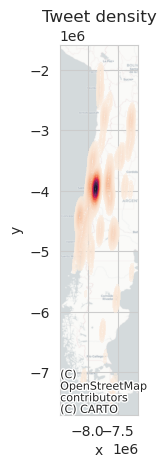

In [ ]:
# visualise a simple kde-plot
chile_gdf = chile_gdf.to_crs(3857)
chile_gdf['centroid'] = chile_gdf['geom'].centroid
chile_gdf['x'] = chile_gdf['centroid'].x
chile_gdf['y'] = chile_gdf['centroid'].y
chile_gdf = chile_gdf.to_crs(4326)

# then visualise the spatial tweet distribution
fig, ax = plt.subplots()
kde_plt = sns.kdeplot(x='x', y='y', data=chile_gdf.sample(50000),
                n_levels=50, fill=True, alpha=0.55,
                cmap='rocket_r', ax=ax)
chile_gdf.to_crs(3857).sample(10).plot(color='none', edgecolor='none', ax=ax, linewidth=0.2, legend=True)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title(f"Tweet density")

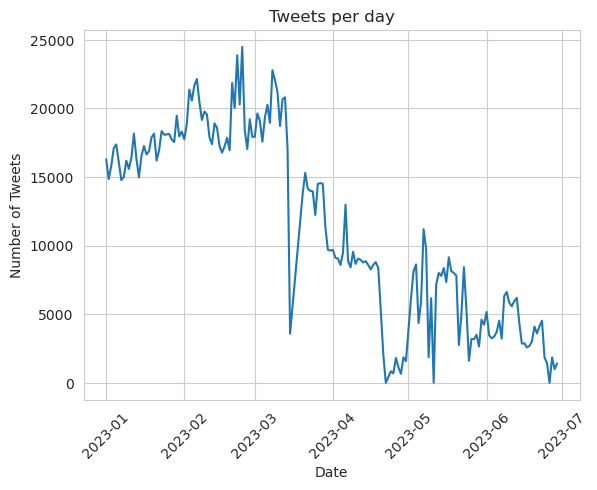

In [ ]:
# and also the temporal distribution
daily_counts: pd.DataFrame = chile_gdf.groupby(chile_gdf['date'].dt.date).size()

# plot the daily tweet count
ax = sns.lineplot(x=daily_counts.index, y=daily_counts.values)
ax.set_title(f"Tweets per day")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Tweets")
ax.tick_params(axis='x', rotation=45)

In [ ]:
chile_gdf.to_parquet(os.path.join(DATA_PATH, 'processed', 'chile', 'chile_tweets_merged.parquet'))

## 3. Relatedness Classification
Lastly, we need relatedness labels to create our labelling samples. The goal is to use a 66%/33% split of the classes "1" and "0" to create our samples to label.

In [4]:
chile_gdf: gpd.GeoDataFrame = gpd.read_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'chile', 'chile_tweets_merged.parquet'))
chile_gdf.head()

,message_id,date,text,tweet_lang,geom,photo_url,text_raw,related,centroid,x,y
0,1621573711173238785,2023-02-03 18:17:54,"@user Digo lo mismo, pero a mi norte querido.E...",es,POINT (-70.65962 -33.45216),None,"@charmedark Digo lo mismo, pero a mi norte que...",NaN,POINT (-7865792.417 -3955475.786),-7.865792e+06,-3.955476e+06
1,1621573714755162112,2023-02-03 18:17:55,@user Cara de tontorron,es,POINT (-70.60266 -33.45441),None,@AlexusChile Cara de tontorron,NaN,POINT (-7859451.882 -3955776.321),-7.859452e+06,-3.955776e+06
2,1621573724855042048,2023-02-03 18:17:58,@user Hola cabrita,es,POINT (-73.21143 -41.74251),None,@lorena89785516 Hola cabrita,NaN,POINT (-8149858.774 -5122486.762),-8.149859e+06,-5.122487e+06
3,1632169457459101698,2023-03-05 00:01:37,enamorada de estos colores 🤍❤🤍😍,es,POINT (-68.78007 -32.90174),None,enamorada de estos colores 🤍❤🤍😍,NaN,POINT (-7656562.035 -3882268.18),-7.656562e+06,-3.882268e+06
4,1632169476740268033,2023-03-05 00:01:42,@user Hola mi querida amiga Pilar !! Qué tenga...,es,POINT (-71.37439 -34.64261),None,@_p_i_l_a_r Hola mi querida amiga Pilar !! Qué...,NaN,POINT (-7945360.695 -4115419.187),-7.945361e+06,-4.115419e+06


In [7]:
chile_to_label: gpd.GeoDataFrame = build_dataset_relatedness(gdf=chile_gdf, max_size=10000)
print(chile_to_label.shape)
chile_to_label.head()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/918 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/652 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Device set to use cuda
100%|██████████| 10000/10000 [2:07:02<00:00,  1.31it/s]


(10000, 13)


,level_0,index,message_id,date,text,tweet_lang,geom,photo_url,text_raw,related,centroid,x,y
0,0,1107255,1616045924605739008,2023-01-19 12:12:27,@user La cara de pelotudos q les quedará a muc...,es,POINT (-68.46836 -33.08063),None,@Gracielamafald2 La cara de pelotudos q les qu...,0,POINT (-7621862.970650541 -3906010.5463226982),-7.621863e+06,-3.906011e+06
1,1,1995127,1620985923226959872,2023-02-02 03:22:15,"@user @user Se ve q están cerca,cuidado chicos",es,POINT (-71.51565 -33.02636),None,"@neme_munoz @jocee__g Se ve q están cerca,cuid...",0,POINT (-7961085.296472012 -3898803.0034869104),-7.961085e+06,-3.898803e+06
2,2,228606,1632606303896981504,2023-03-06 04:57:29,@user Jamas te haría eso,es,POINT (-69.64635 -49.19601),None,@frqnnaranda Jamas te haría eso,0,POINT (-7752996.495908837 -6308186.126790726),-7.752996e+06,-6.308186e+06
3,3,884885,1634705695672025092,2023-03-11 23:59:43,@user Conversa muy amena y risas por doquier c...,es,POINT (-70.61076 -33.42949),None,@La_TurcaPorfia Conversa muy amena y risas por...,0,POINT (-7860353.73640656 -3952450.655321753),-7.860354e+06,-3.952451e+06
4,4,1646856,1619365408133492737,2023-01-28 16:02:54,@user por pedofilo???...a muy bien ....,es,POINT (-70.65962 -33.45216),None,@ViralizandoAndo por pedofilo???...a muy bien ...,0,POINT (-7865792.4171085 -3955475.785678141),-7.865792e+06,-3.955476e+06


In [6]:
chile_to_label.groupby('related').size()

,0
related,
0,3300
1,6700


In [9]:
chile_to_label['centroid'] = gpd.GeoSeries(chile_to_label['centroid'], crs=3857)
chile_to_label.to_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'chile', 'chile_tweets_to_label.parquet'))

Before storing the final dataframe, let's also translate the tweets to English.

In [4]:
chile_to_label = gpd.read_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'chile', 'chile_tweets_to_label.parquet'))
chile_to_label['text_en'] = translate_google(texts=chile_to_label['text'])
chile_to_label.head()

100%|██████████| 10000/10000 [2:35:17<00:00,  1.07it/s]


,level_0,index,message_id,date,text,tweet_lang,geom,photo_url,text_raw,related,centroid,x,y,text_en
0,0,1107255,1616045924605739008,2023-01-19 12:12:27,@user La cara de pelotudos q les quedará a muc...,es,POINT (-68.46836 -33.08063),None,@Gracielamafald2 La cara de pelotudos q les qu...,0,POINT (-7621862.971 -3906010.546),-7.621863e+06,-3.906011e+06,@user The look of idiocy that many will have o...
1,1,1995127,1620985923226959872,2023-02-02 03:22:15,"@user @user Se ve q están cerca,cuidado chicos",es,POINT (-71.51565 -33.02636),None,"@neme_munoz @jocee__g Se ve q están cerca,cuid...",0,POINT (-7961085.296 -3898803.003),-7.961085e+06,-3.898803e+06,"@user @user It seems that they are close, be c..."
2,2,228606,1632606303896981504,2023-03-06 04:57:29,@user Jamas te haría eso,es,POINT (-69.64635 -49.19601),None,@frqnnaranda Jamas te haría eso,0,POINT (-7752996.496 -6308186.127),-7.752996e+06,-6.308186e+06,@user I would never do that to you
3,3,884885,1634705695672025092,2023-03-11 23:59:43,@user Conversa muy amena y risas por doquier c...,es,POINT (-70.61076 -33.42949),None,@La_TurcaPorfia Conversa muy amena y risas por...,0,POINT (-7860353.736 -3952450.655),-7.860354e+06,-3.952451e+06,@user Very pleasant conversation and laughter ...
4,4,1646856,1619365408133492737,2023-01-28 16:02:54,@user por pedofilo???...a muy bien ....,es,POINT (-70.65962 -33.45216),None,@ViralizandoAndo por pedofilo???...a muy bien ...,0,POINT (-7865792.417 -3955475.786),-7.865792e+06,-3.955476e+06,@user for pedophile???...very well....


In [5]:
chile_to_label.to_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'chile', 'chile_tweets_to_label.parquet'))